In [524]:
# Kaggle 타이타닉 문제는 타이타닉의 승객 중에 생존 유무를 예측하는 것이다.
# 아래의 코드는 https://www.kaggle.com/startupsci/titanic-data-science-solutions 를 참고해서 작성하였다.

In [525]:
# Numpy, Pandas 불러오기
import numpy as np
import pandas as pd

# 시각화 라이브러리 불러오기
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn 머신러닝 라이브러리 불러오기
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier

In [526]:
# 데이터 불러오기
train = pd.read_csv('/python/titanic/train.csv')
test = pd.read_csv('/python/titanic/test.csv')
total = [train, test]

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  
--------------------
       PassengerId      Pclass         Age       SibSp      

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Fare'}>]], dtype=object)

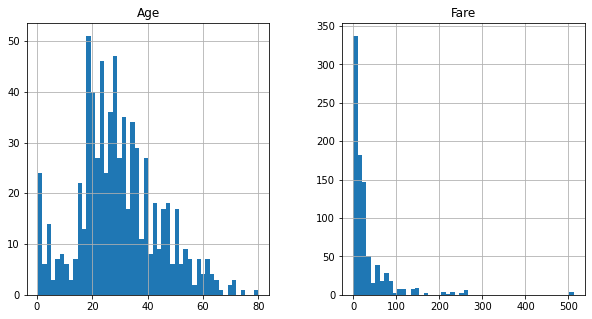

In [527]:
# 데이터 요약
print(train.describe())
print('-'*20)
print(test.describe())

# Fare에 이상치가 존재한다.
train.loc[:,['Age', 'Fare']].hist(bins=50, figsize=(10, 5))

In [528]:
# Training, Test 세트의 결측치 확인하기
# Age, Cabin, Fare, Embarked에서 결측치가 있다.
print(train.isnull().sum())
print('-'*20)
print(test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
--------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [529]:
# 카테고리형 특성들의 생존율과의 연관성을 살펴본다.
# 여기서 알수 있는 것은 여성의 생존율이 높고,
# 선실등급이 높을수록 생존율이 높다는 것이다.
print(train[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print('-'*20)
print(train[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print('-'*20)
print(train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print('-'*20)
print(train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False))

   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
--------------------
   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000
--------------------
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
--------------------
      Sex  Survived
0  female  0.742038
1    male  0.188908


In [530]:
# Ticket에서는 유의미한 특성을 찾아내지 못해서 Ticket을 제거합니다.
print(train['Ticket'].value_counts())

train['Ticket'].value_counts().hist(bins=50, figsize=(10, 5))
for data in total:
    data['Has_Same_Ticket'] = 1 if data['Ticket'].value_counts() >= 2 else 0

print(train)

for data in total:
    data.drop(['Ticket'], axis=1, inplace=True)

347082      7
1601        7
CA. 2343    7
347088      6
CA 2144     6
           ..
239856      1
342826      1
11813       1
11752       1
28134       1
Name: Ticket, Length: 681, dtype: int64


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [430]:
print(train['Cabin'].value_counts())
print('-'*20)

# Cabin 값이 존재하면 Has_Cabin = 1, 없으면 0이다. Cabin은 삭제한다.
for data in total:
    data['Has_Cabin'] = data['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
    data.drop(['Cabin'], axis=1, inplace=True)

# Has_Cabin은 생존율에 연관이 있는 것으로 보인다.
print(train[['Has_Cabin', 'Survived']].groupby(['Has_Cabin'], as_index=False).mean().sort_values(by='Survived', ascending=False))

G6             4
C23 C25 C27    4
B96 B98        4
E101           3
D              3
              ..
A23            1
A20            1
A5             1
C30            1
D10 D12        1
Name: Cabin, Length: 147, dtype: int64
--------------------
   Has_Cabin  Survived
1          1  0.666667
0          0  0.299854


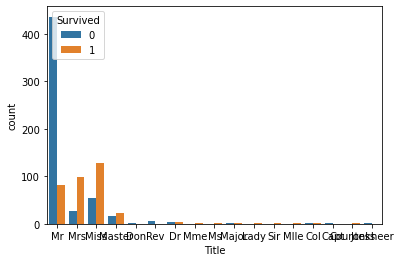

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1
------------------------------
    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4  Others  0.347826


In [431]:
# Name에서 Title으로 추출해서 구분한다.
for data in total:
    data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# 여성과 Master라는 Title을 가진 남성이 생존율이 높다.
sns.countplot(data=train, x='Title', hue='Survived')
plt.show()
print(pd.crosstab(train['Title'], train['Sex']))
print('-'*30)

# 희귀한 Title은 Others로 변환한다.
for data in total:
    data['Title'] = data['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',\
        'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Others')
    data['Title'] = data['Title'].replace('Mlle', 'Miss')
    data['Title'] = data['Title'].replace('Ms', 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')

# Title과 생존율과의 연관성을 살펴본다.
print(train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

# Title을 카테고리형으로 변환하고 이후에 Name은 삭제한다.
for data in total:
    data['Title'] = data['Title'].astype('category').cat.codes
    data.drop(['Name'], axis=1, inplace=True)

   Pclass       Fare
0       1  84.154687
1       2  20.662183
2       3  13.675550


array([[<AxesSubplot:title={'center':'Fare'}>]], dtype=object)

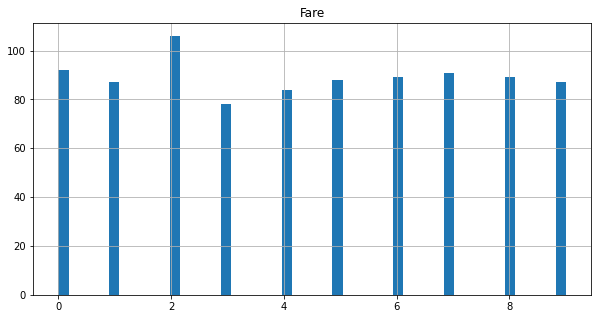

In [432]:
# Pclass, 즉 선실등급에 따른 Fare가 관련있음을 확인할 수 있다.
print(train[['Fare', 'Pclass']].groupby(['Pclass'], as_index=False).mean())

# Fare 결측치를 Pclass 기준으로 중간값을 채우고 분위수 기준으로 구간을 나눈다.
for data in total:
    data['Fare'].fillna(data.groupby('Pclass')['Fare'].transform('median'), inplace=True)
    data['Fare'] = pd.qcut(data['Fare'], 10, labels=False)

train.loc[:, ['Fare']].hist(bins=50, figsize=(10, 5))

In [433]:
# Sex를 0과 1로 나눕니다.
for data in total:
    data['Sex'] = data['Sex'].map({'male': 0, 'female': 1}).astype(int)

   Pclass        Age
0       1  38.233441
1       2  29.877630
2       3  25.140620
------------------------------
   Sex        Age
0    0  30.726645
1    1  27.915709
------------------------------
   Sex*Pclass        Age
0           3  41.281386
1           4  34.611765
2           6  30.740707
3           8  28.722973
4           9  26.507589
5          12  21.750000


array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

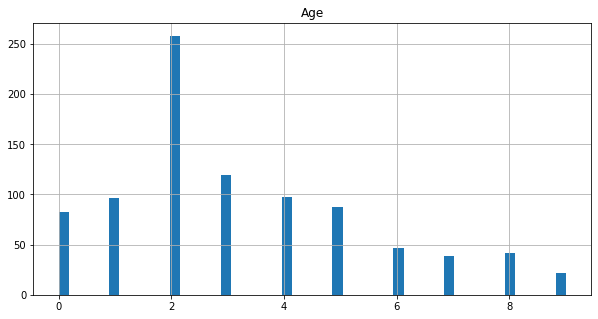

In [434]:
# Age는 Pclass와 Sex와 연관이 있는 것으로 보인다.
print(train[['Age', 'Pclass']].groupby(['Pclass'], as_index=False).mean())
print('-'*30)
print(train[['Age', 'Sex']].groupby(['Sex'], as_index=False).mean())
print('-'*30)

# Sex*Pclass 특성을 추가한다.
for data in total:
    data['Sex*Pclass'] = (data['Sex'] + 3) * data['Pclass']

print(train[['Age', 'Sex*Pclass']].groupby(['Sex*Pclass'], as_index=False).mean())

# Age의 결측치를 Sex*Pclass을 기준으로 중간값으로 채운다.
for data in total:
    data['Age'].fillna(data.groupby('Sex*Pclass')['Age'].transform('median'), inplace=True)

# Sex*Pclass 특성을 제거한다.
for data in total:
    data.drop(['Sex*Pclass'], axis=1, inplace=True)

# Age를 구간을 임의로 나눠서 분류한다.
for data in total:
    data['Age'] = pd.cut(data['Age'], [0, 15, 20, 25, 30, 35, 40, 45, 50, 60, 100], labels=False)

train.loc[:,['Age']].hist(bins=50, figsize=(10, 5))

In [328]:
# 본인이 속한 가족구성원의 수를 FamilySize에 저장한다.
for data in total:
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

# 가족 구성원의 수와 생존율에 연관성을 확인한다.
# 구성원이 2~4인 핵가족의 생존율이 높아보인다.
print(train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False))

# 핵가족인 경우는 1, 아니면 0이다.
for data in total:
    data['Nuclear'] = 0
    data.loc[(2 <= data['FamilySize']) & (data['FamilySize'] <= 4), 'Nuclear'] = 1

# FamilySize를 제거한다.
for data in total:
    data.drop(['FamilySize'], axis=1, inplace=True)

   FamilySize  Survived
3           4  0.724138
2           3  0.578431
1           2  0.552795
6           7  0.333333
0           1  0.303538
4           5  0.200000
5           6  0.136364
7           8  0.000000
8          11  0.000000


In [329]:
# 출발항 결측치는 가장 많은 출발항 S로 채운다.
print(train['Embarked'].value_counts())
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)

# Embarked를 카테고리 수치화한다.
for data in total:
    data['Embarked'] = data['Embarked'].astype('category').cat.codes

S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [330]:
X_train = train.drop(['PassengerId', 'Survived'], axis=1)
Y_train = train['Survived']
X_test = test.drop('PassengerId', axis=1).copy()

print(X_train.head(10))

   Pclass  Sex  Age  SibSp  Parch  Fare  Embarked  Has_Cabin  Title  Nuclear
0       3    0    3      1      0     0         2          0      2        1
1       1    1    6      1      0     8         0          1      3        1
2       3    1    4      0      0     2         2          0      1        0
3       1    1    5      1      0     8         2          1      3        1
4       3    0    5      0      0     2         2          0      2        0
5       3    0    3      0      0     3         1          0      2        0
6       1    0    9      0      0     8         2          1      2        0
7       3    0    0      3      1     5         2          0      0        0
8       3    1    4      0      2     4         2          0      3        1
9       2    1    1      1      0     7         0          0      3        1


In [331]:
# 최소값을 0, 최대값을 1로 만드는 스케일링을 적용한다.
scaler = MinMaxScaler()
scaler.fit_transform(X_train)
scaler.fit_transform(X_test)

array([[1.  , 0.  , 0.5 , ..., 0.  , 0.5 , 0.  ],
       [1.  , 1.  , 0.8 , ..., 0.  , 0.75, 1.  ],
       [0.5 , 0.  , 1.  , ..., 0.  , 0.5 , 0.  ],
       ...,
       [1.  , 0.  , 0.6 , ..., 0.  , 0.5 , 0.  ],
       [1.  , 0.  , 0.3 , ..., 0.  , 0.5 , 0.  ],
       [1.  , 0.  , 0.3 , ..., 0.  , 0.  , 1.  ]])

In [332]:
# 교차검증을 적용한다.
cv = KFold(n_splits=10, shuffle=True, random_state=1)

In [333]:
# SVC
svc = SVC(random_state=1)
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100],\
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100],\
              'degree': [1, 2, 3, 4, 5, 6]}
grid_svc = GridSearchCV(svc, param_grid=parameters, cv=cv, n_jobs=-1, verbose=3)
grid_svc.fit(X_train, Y_train)
result_grid_svc = pd.DataFrame(grid_svc.cv_results_)
print(result_grid_svc[['params', 'mean_test_score', 'rank_test_score',\
                           ]])
print('SVC의 그리드서치 최고 모델: {}'.format(grid_svc.best_estimator_))
print('SVC의 그리드서치 최고 파라미터: {}'.format(grid_svc.best_params_))
score_grid_svc = round(grid_svc.best_score_ * 100, 3)
print('SVC의 그리츠서치 최고 정확도: {}'.format(score_grid_svc))
best_grid_svc = grid_svc.best_estimator_

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


KeyboardInterrupt: 

In [293]:
# AdaBoost
adaboost = AdaBoostClassifier(random_state=1)
parameters = {'n_estimators': [20, 50, 100],\
              'learning_rate': [0.00001, 0.0001, 0.001, 0.01]}
grid_adaboost = GridSearchCV(adaboost, param_grid=parameters, cv=cv, n_jobs=-1, verbose=3)
grid_adaboost.fit(X_train, Y_train)
result_grid_adaboost = pd.DataFrame(grid_adaboost.cv_results_)
print(result_grid_adaboost[['params', 'mean_test_score', 'rank_test_score',\
                           ]])
print('AdaBoost의 그리드서치 최고 모델: {}'.format(grid_adaboost.best_estimator_))
print('AdaBoost의 그리드서치 최고 파라미터: {}'.format(grid_adaboost.best_params_))
score_grid_adaboost = round(grid_adaboost.best_score_ * 100, 3)
print('AdaBoost의 그리드서치 최고 정확도: {}'.format(score_grid_adaboost))
best_grid_adaboost = grid_adaboost.best_estimator_

Fitting 10 folds for each of 12 candidates, totalling 120 fits
                                            params  mean_test_score  \
0    {'learning_rate': 0.0001, 'n_estimators': 50}         0.786816   
1   {'learning_rate': 0.0001, 'n_estimators': 100}         0.786816   
2   {'learning_rate': 0.0001, 'n_estimators': 150}         0.786816   
3   {'learning_rate': 0.0001, 'n_estimators': 200}         0.786816   
4     {'learning_rate': 0.001, 'n_estimators': 50}         0.786816   
5    {'learning_rate': 0.001, 'n_estimators': 100}         0.786816   
6    {'learning_rate': 0.001, 'n_estimators': 150}         0.786816   
7    {'learning_rate': 0.001, 'n_estimators': 200}         0.786816   
8      {'learning_rate': 0.01, 'n_estimators': 50}         0.786816   
9     {'learning_rate': 0.01, 'n_estimators': 100}         0.786816   
10    {'learning_rate': 0.01, 'n_estimators': 150}         0.786816   
11    {'learning_rate': 0.01, 'n_estimators': 200}         0.786816   

    rank_test

In [294]:
# XgBoost
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss',\
                    silent=1, random_state=1)
parameters = {'n_estimators': [20, 50, 100, 200], 'max_depth': [1, 2, 3, 4, 5],\
              'learing_rate': [0.0001, 0.001, 0.01]}
grid_xgb = GridSearchCV(xgb, param_grid=parameters, cv=cv, n_jobs=-1)
grid_xgb.fit(X_train, Y_train, early_stopping_rounds=100, eval_set= [(X_train, Y_train)])
result_grid_xgb = pd.DataFrame(grid_xgb.cv_results_)
print(result_grid_xgb[['params', 'mean_test_score', 'rank_test_score',\
                           ]])
print('XGB의 그리드서치 최고 모델: {}'.format(grid_xgb.best_estimator_))
print('XGB의 그리드서치 최고 파라미터: {}'.format(grid_xgb.best_params_))
score_grid_xgb = round(grid_xgb.best_score_ * 100, 3)
print('XGB의 그리츠서치 최고 정확도: {}'.format(score_grid_xgb))
best_grid_xgb = grid_xgb.best_estimator_

[00:39:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "learing_rate", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-logloss:0.60867
[1]	validation_0-logloss:0.56522
[2]	validation_0-logloss:0.54016
[3]	validation_0-logloss:0.51955
[4]	validation_0-logloss:0.50431
[5]	validation_0-logloss:0.49409
[6]	validation_0-logloss:0.48592
[7]	validation_0-logloss:0.47827
[8]	validation_0-logloss:0.47236
[9]	validation_0-logloss:0.46690
[10]	validation_0-logloss:0.46258
[11]	validation_0-logloss:0.45897
[12]	validation_0-logloss:0.45492
[13]	validation_0-logloss:0.45166
[14]	validation_0-logloss:0.44884
[15]	validation_0-logloss:0.44592
[16]	validation_0-logloss:0.44319
[17]	validation_0-logloss:0.44

In [295]:
# Random Forest
random_forest = RandomForestClassifier(random_state=1)
parameters = {'max_depth': [2, 3, 4, 5, 6], 'max_features': [3, 4, 5, 6],\
              'n_estimators': [10, 20, 50],
              'min_samples_leaf': [2, 3, 4, 5],\
              'min_samples_split': [2, 3, 4, 5]}
grid_random_forest = GridSearchCV(random_forest, param_grid=parameters, cv=cv, n_jobs=-1, verbose=3)
grid_random_forest.fit(X_train, Y_train)
result_grid_random_forest = pd.DataFrame(grid_random_forest.cv_results_)
print(result_grid_random_forest[['params', 'mean_test_score', 'rank_test_score',\
                           ]])
print('랜덤 포레스트의 그리드서치 최고 모델: {}'.format(grid_random_forest.best_estimator_))
print('랜덤 포레스트의 그리드서치 최고 파라미터: {}'.format(grid_random_forest.best_params_))
score_grid_random_forest = round(grid_random_forest.best_score_ * 100, 3)
print('랜덤 포레스트의 그리드서치 최고 정확도: {}'.format(score_grid_random_forest))
best_grid_random_forest = grid_random_forest.best_estimator_

Fitting 10 folds for each of 960 candidates, totalling 9600 fits
                                                params  mean_test_score  \
0    {'max_depth': 2, 'max_features': 3, 'min_sampl...         0.791311   
1    {'max_depth': 2, 'max_features': 3, 'min_sampl...         0.804757   
2    {'max_depth': 2, 'max_features': 3, 'min_sampl...         0.798015   
3    {'max_depth': 2, 'max_features': 3, 'min_sampl...         0.791311   
4    {'max_depth': 2, 'max_features': 3, 'min_sampl...         0.804757   
..                                                 ...              ...   
955  {'max_depth': 6, 'max_features': 6, 'min_sampl...         0.813770   
956  {'max_depth': 6, 'max_features': 6, 'min_sampl...         0.820487   
957  {'max_depth': 6, 'max_features': 6, 'min_sampl...         0.821635   
958  {'max_depth': 6, 'max_features': 6, 'min_sampl...         0.813770   
959  {'max_depth': 6, 'max_features': 6, 'min_sampl...         0.820487   

     rank_test_score  
0          

In [296]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier(random_state=1)
parameters = {'learning_rate': [(0.1) ** n for n in range(10)],\
              'n_estimators': np.arange(10, 3000, 10),\
              'max_depth': np.arange(1, 10, 1),\
              'max_features': np.arange(1, 5, 1),\
              'min_samples_leaf': np.arange(1, 10, 1),\
              'min_samples_split': np.arange(2, 10, 1),\
              }
random_gbc = RandomizedSearchCV(gbc, n_iter=20, param_distributions=parameters, cv=cv, verbose=2, n_jobs=-1, refit=True)
random_gbc.fit(X_train, Y_train)
result_random_gbc = pd.DataFrame(random_gbc.cv_results_)
print(result_random_gbc[['params', 'mean_test_score', 'rank_test_score'\
                 ]])
print('GBC의 랜덤서치 최고 모델: {}'.format(random_gbc.best_estimator_))
print('GBC의 랜덤서치 최적 파라미터: {}'.format(random_gbc.best_params_))
score_random_gbc = round(random_gbc.best_score_ * 100, 3)
print('GBC의 랜덤서치 최고점수: {}'.format(score_random_gbc))
best_random_gbc = random_gbc.best_estimator_

Fitting 10 folds for each of 20 candidates, totalling 200 fits
                                               params  mean_test_score  \
0   {'n_estimators': 2220, 'min_samples_split': 8,...         0.813770   
1   {'n_estimators': 2580, 'min_samples_split': 2,...         0.745281   
2   {'n_estimators': 870, 'min_samples_split': 8, ...         0.736355   
3   {'n_estimators': 80, 'min_samples_split': 4, '...         0.792447   
4   {'n_estimators': 1620, 'min_samples_split': 2,...         0.817141   
5   {'n_estimators': 1140, 'min_samples_split': 3,...         0.616192   
6   {'n_estimators': 670, 'min_samples_split': 3, ...         0.823845   
7   {'n_estimators': 2690, 'min_samples_split': 5,...         0.616192   
8   {'n_estimators': 2240, 'min_samples_split': 9,...         0.616192   
9   {'n_estimators': 2370, 'min_samples_split': 9,...         0.809276   
10  {'n_estimators': 2320, 'min_samples_split': 9,...         0.616192   
11  {'n_estimators': 2130, 'min_samples_split': 2

In [297]:
# Multilayer Perceptron
mlp = MLPClassifier(hidden_layer_sizes=(100))
parameters = {'alpha': [(0.1) ** n for n in range(10)],\
               'solver': ['sgd', 'adam'],\
               'activation': ['tanh', 'relu', 'logistic'],\
               'max_iter': np.arange(10, 1000, 10),\
               'batch_size': np.arange(1, 10, 1)}
random_mlp = RandomizedSearchCV(mlp, param_distributions=parameters, random_state=1,\
                                n_iter=20, n_jobs=-1, cv=cv, verbose=3)
random_mlp.fit(X_train, Y_train)
result_random_mlp = pd.DataFrame(random_mlp.cv_results_)
print(result_random_mlp[['params', 'mean_test_score', 'rank_test_score'\
                        ]])
print('MLP의 랜덤서치 최고 성능 모델: {}'.format(random_mlp.best_estimator_))
print('MLP의 랜덤서치 최적 파라미터: {}'.format(random_mlp.best_params_))
score_random_mlp = round(random_mlp.best_score_ * 100, 3)
print('MLP의 랜덤서치 최고점수: {}'.format(score_random_mlp))
best_random_mlp = random_mlp.best_estimator_

Fitting 10 folds for each of 20 candidates, totalling 200 fits
                                               params  mean_test_score  \
0   {'solver': 'adam', 'max_iter': 680, 'batch_siz...         0.815918   
1   {'solver': 'sgd', 'max_iter': 480, 'batch_size...         0.819413   
2   {'solver': 'sgd', 'max_iter': 230, 'batch_size...         0.817154   
3   {'solver': 'adam', 'max_iter': 200, 'batch_siz...         0.815968   
4   {'solver': 'adam', 'max_iter': 810, 'batch_siz...         0.810424   
5   {'solver': 'adam', 'max_iter': 820, 'batch_siz...         0.806991   
6   {'solver': 'adam', 'max_iter': 460, 'batch_siz...         0.820524   
7   {'solver': 'adam', 'max_iter': 860, 'batch_siz...         0.802509   
8   {'solver': 'sgd', 'max_iter': 290, 'batch_size...         0.807029   
9   {'solver': 'sgd', 'max_iter': 230, 'batch_size...         0.818252   
10  {'solver': 'adam', 'max_iter': 90, 'batch_size...         0.814856   
11  {'solver': 'sgd', 'max_iter': 980, 'batch_siz

In [298]:
# Decision Tree
decision_tree = DecisionTreeClassifier(random_state=1)
parameters = {'criterion': ['gini', 'entropy'],\
              'splitter': ['best', 'random'],\
               'max_depth': [2, 3, 4, 5, 6], 'max_features': [3, 4, 5, 6],\
              'min_samples_leaf': [2, 3, 4, 5],\
              'min_samples_split': [2, 3, 4, 5]}
grid_decision_tree = GridSearchCV(decision_tree, param_grid=parameters, cv=cv, n_jobs=-1, verbose=3)
grid_decision_tree.fit(X_train, Y_train)
result_grid_decision_tree = pd.DataFrame(grid_decision_tree.cv_results_)
print(result_grid_decision_tree[['params', 'mean_test_score', 'rank_test_score',\
                           ]])
print('결정트리의 그리드서치 최고 모델: {}'.format(grid_decision_tree.best_estimator_))
print('결정트리의 그리드서치 최고 파라미터: {}'.format(grid_decision_tree.best_params_))
score_grid_decision_tree = round(grid_decision_tree.best_score_ * 100, 3)
print('결정트리의 그리드서치 최고 정확도: {}'.format(score_grid_decision_tree))
best_grid_decision_tree = grid_decision_tree.best_estimator_

Fitting 10 folds for each of 1280 candidates, totalling 12800 fits
                                                 params  mean_test_score  \
0     {'criterion': 'gini', 'max_depth': 2, 'max_fea...         0.784594   
1     {'criterion': 'gini', 'max_depth': 2, 'max_fea...         0.710499   
2     {'criterion': 'gini', 'max_depth': 2, 'max_fea...         0.784594   
3     {'criterion': 'gini', 'max_depth': 2, 'max_fea...         0.710499   
4     {'criterion': 'gini', 'max_depth': 2, 'max_fea...         0.784594   
...                                                 ...              ...   
1275  {'criterion': 'entropy', 'max_depth': 6, 'max_...         0.800275   
1276  {'criterion': 'entropy', 'max_depth': 6, 'max_...         0.804794   
1277  {'criterion': 'entropy', 'max_depth': 6, 'max_...         0.800275   
1278  {'criterion': 'entropy', 'max_depth': 6, 'max_...         0.804794   
1279  {'criterion': 'entropy', 'max_depth': 6, 'max_...         0.800275   

      rank_test_scor

In [299]:
# Perceptron
perceptron = Perceptron(random_state=1)
perceptron.fit(X_train, Y_train)
score_perceptron = round(cross_val_score(perceptron, X_train, Y_train, cv=cv).mean() * 100, 3)
print('Perceptron의 교차 검증 점수 : {}.'.format(score_perceptron))

# GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, Y_train)
score_gnb = round(cross_val_score(gnb, X_train, Y_train, cv=cv).mean() * 100, 3)
print('GaussainNB의 교차 검증 점수 : {}'.format(score_gnb))

# Logistic Regression
logreg = LogisticRegression(max_iter=2000, random_state=1)
logreg.fit(X_train, Y_train)
score_logreg = round(cross_val_score(logreg, X_train, Y_train, cv=cv).mean() * 100, 3)
print('로지스틱회귀의 교차 검증 점수 : {}'.format(score_logreg))

# Linear SVC
linear_svc = LinearSVC(max_iter=10000, random_state=1)
linear_svc.fit(X_train, Y_train)
score_linear_svc = round(cross_val_score(linear_svc, X_train, Y_train, cv=cv).mean() * 100, 3)
print('LinearSVC의 교차 검증 점수 : {}'.format(score_linear_svc))

# K-Neighbors Classfier
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
score_knn = round(cross_val_score(knn, X_train, Y_train, cv=cv).mean() * 100, 3)
print('KNN의 교차 검증 점수 : {}'.format(score_knn))

# Stochastic Gradient Decent
sgd = SGDClassifier(random_state=1)
sgd.fit(X_train, Y_train)
score_sgd = round(cross_val_score(sgd, X_train, Y_train, cv=cv).mean() * 100, 3)
print('SGD의 교차 검증 점수 : {}'.format(score_sgd))

Perceptron의 교차 검증 점수 : 74.084.
GaussainNB의 교차 검증 점수 : 77.228
로지스틱회귀의 교차 검증 점수 : 80.251
LinearSVC의 교차 검증 점수 : 80.587
KNN의 교차 검증 점수 : 78.569
SGD의 교차 검증 점수 : 72.194


In [300]:
# 머신러닝 모델 중에 가장 높은 교차검증 점수를 갖는 모델을 선택한다.
models = pd.DataFrame([['Perceptron', score_perceptron, perceptron],\
                      ['GaussianNB', score_gnb, gnb], ['KNN', score_knn, knn],\
                      ['Random Forest', score_grid_random_forest,\
                        best_grid_random_forest],\
                      ['Decision Tree', score_grid_decision_tree,\
                        grid_decision_tree],\
                      ['Gradient Boosting Classifier', score_random_gbc,\
                        best_random_gbc],\
                      ['MLP', score_random_mlp, best_random_mlp],\
                      ['Linear SVC', score_linear_svc, linear_svc],\
                      ['Stochastic Gradient Decent', score_sgd, sgd],\
                      ['Logistic Regression', score_logreg, logreg],\
                      ['SVC', score_grid_svc, best_grid_svc],\
                      ['AdaBoost', score_grid_adaboost, best_grid_adaboost],\
                      ['XGB', score_grid_xgb, best_grid_xgb]],\
                    columns=['Model', 'Score', 'Estimator'])
sorted_models = models.sort_values(by=['Score'], axis=0, ascending=False, ignore_index=True).loc[:,['Model','Score']]
best_estimator = models.sort_values(by=['Score'], axis=0, ascending=False, ignore_index=True).loc[:,['Estimator','Score']]
print(sorted_models)
print('-' * 40)
print('교차 검증 점수가 가장 높은 모델은 {}이고 점수는 {}이다'.format(sorted_models.iloc[0, 0], sorted_models.iloc[0, 1]))
Y_pred = best_estimator.iloc[0, 0].predict(X_test)

                           Model   Score
0                  Random Forest  83.509
1                  Decision Tree  83.285
2                            XGB  82.834
3                            SVC  82.724
4   Gradient Boosting Classifier  82.385
5                            MLP  82.052
6                     Linear SVC  80.587
7            Logistic Regression  80.251
8                       AdaBoost  78.682
9                            KNN  78.569
10                    GaussianNB  77.228
11                    Perceptron  74.084
12    Stochastic Gradient Decent  72.194
----------------------------------------
교차 검증 점수가 가장 높은 모델은 Random Forest이고 점수는 83.509이다


In [301]:
# 결과를 CSV로 저장한다.
submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': Y_pred})
submission.to_csv('C:/python/titanic/submission.csv', index=False)